# Analysis of VELMA runoff simulations

In [1]:
import __init__
import scripts.config as config
import numpy as np
import pandas as pd
import tempfile
import datetime
import ipywidgets as widgets
from ipywidgets import interact
from natsort import natsorted
import os
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.font_manager import FontProperties
import seaborn as sns
# import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
from functools import reduce

In [2]:
# Plotting parameters

XSMALL_SIZE = 6
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 140

In [11]:
# Getting daily runoff results from simulations

results_dir = config.velma_data.parents[1] / 'results' / 'calibration'

nse_start = pd.to_datetime('01-01-2004')
nse_end = pd.to_datetime('12-31-2007')

all_sims = natsorted(next(os.walk(results_dir))[1])
# remove = ['ellsworth_baseline_03_07']
# all_sims = [x for x in all_sims if x not in remove]

sims = []
runoff_sims = []
for sim in all_sims:
    sim_dir = results_dir / sim
    files = os.listdir(sim_dir)
    if 'AnnualHydrologyResults.csv' not in files:
        continue
    sims.append(sim)
    velma_results = pd.read_csv(results_dir / sim / 'DailyResults.csv')
    
    # Format datetime of results
    jday_pad = velma_results['Day'].apply(lambda x: str(x).zfill(3))
    str_year = velma_results['Year'].apply(lambda x: str(x))
    velma_results['date'] = str_year + jday_pad
    rng = pd.to_datetime(velma_results['date'], format='%Y%j')
    velma_results.index = rng
    
    velma_results = velma_results[(velma_results.index >= nse_start) & (velma_results.index <= nse_end)]
    
    runoff_sim = pd.DataFrame(velma_results['Runoff_All(mm/day)_Delineated_Average'])
    runoff_sims.append(runoff_sim)
        


# runoff_sims_stack = np.column_stack(runoff_sims)
runoff_sims_df = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True,
                                            how='outer'), runoff_sims).fillna(np.nan)
runoff_sims_df.columns = sims
# runoff_sims_df = pd.DataFrame(data=runoff_sims_stack, columns=sims, index=rng)
# runoff_sims_df['doy'], runoff_sims_df['year'] = runoff_sims_df.index.dayofyear, runoff_sims_df.index.year

# Get observed runoff
runoff_obs = pd.read_csv(config.velma_data / 'runoff' / 'ellsworth_Q_2003_2007_dummy.csv', names=['runoff_obs'])
runoff_obs.index = pd.date_range('01-01-2003', '12-31-2007')
runoff_obs = runoff_obs[(runoff_obs.index >= nse_start) & (runoff_obs.index <= nse_end)]

In [12]:
# Convert runoff to pivot tables

runoff_sim_yearly = pd.pivot_table(runoff_sims_df, index=runoff_sims_df.index.dayofyear, columns=runoff_sims_df.index.year,
                                   values=sims, dropna=False)

runoff_obs_yearly = pd.pivot_table(runoff_obs, index=runoff_obs.index.dayofyear, columns=runoff_obs.index.year,
                                   values='runoff_obs', dropna=False)

## Plotting

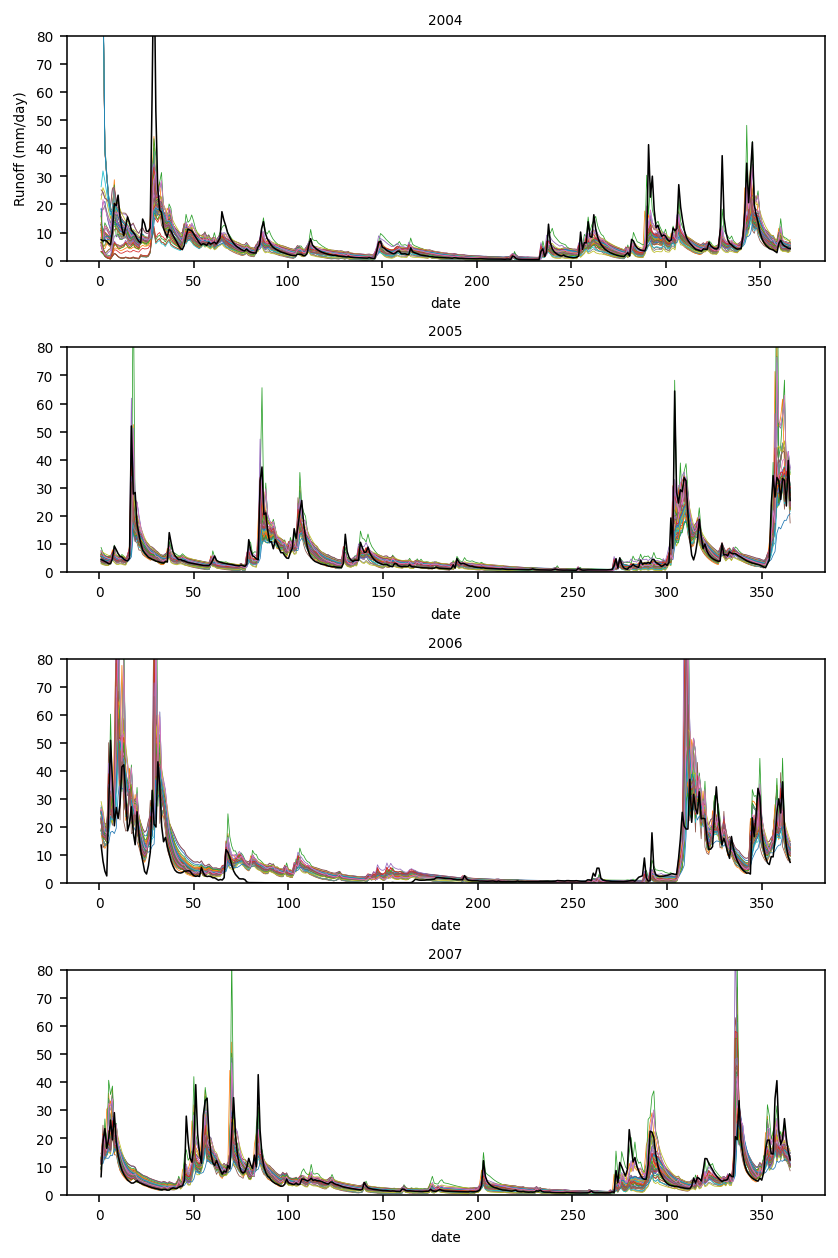

In [13]:
# Plotting all simulations together

years = runoff_obs_yearly.columns.get_level_values(0)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for i, year in enumerate(years):
    axes[i].set_title(year)
    axes[i].set_ylim([0, 80])
    for j, sim in enumerate(sims):
        col = (j * len(years)) + i
        runoff_sim_yearly.iloc[:, col].plot(ax=axes[i], label=sim, linewidth=0.4)
    runoff_obs_yearly.iloc[:, i].plot(ax=axes[i], label='Observed', linewidth=.8, color='black')
#     leg = axes[0].legend(loc='upper left', bbox_to_anchor=(0, 2.5), fancybox=True, ncol=3)
#     for line in leg.get_lines():
#         line.set_linewidth(4.0)
#     axes[0].get_legend().remove()
axes[0].set_ylabel('Runoff (mm/day)')
plt.tight_layout()

In [14]:
# Interactively select which sims to plot

# Plotting a subset of simulations

def plot_selected_sims(runoff_sim_yearly_selected, selected):    
    years = runoff_obs_yearly.columns.get_level_values(0)
    fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
    for i, year in enumerate(years):
        axes[i].set_title(year)
        axes[i].set_ylim([0, 80])
        for j, sim in enumerate(selected):
            col = (j * len(years)) + i
            runoff_sim_yearly_selected.iloc[:, col].plot(ax=axes[i], label=sim, linewidth=0.6)
        runoff_obs_yearly.iloc[:, i].plot(ax=axes[i], label='Observed', linewidth=1, color='black')
    leg = axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3), fancybox=True, ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    axes[0].set_ylabel('Runoff (mm/day)')
    plt.tight_layout()


sel_mul = widgets.SelectMultiple(description="Simulations", options=sims, value=[sims[0]], disabled=False)
@interact(selected=sel_mul)
def interactive_plot(selected):
    tuples = pd.MultiIndex.from_product([selected, years])
    runoff_sim_yearly_sub = runoff_sim_yearly[tuples]
    plot_selected_sims(runoff_sim_yearly_sub, selected)



interactive(children=(SelectMultiple(description='Simulations', index=(0,), options=('ellsworth_baseline_03_07…

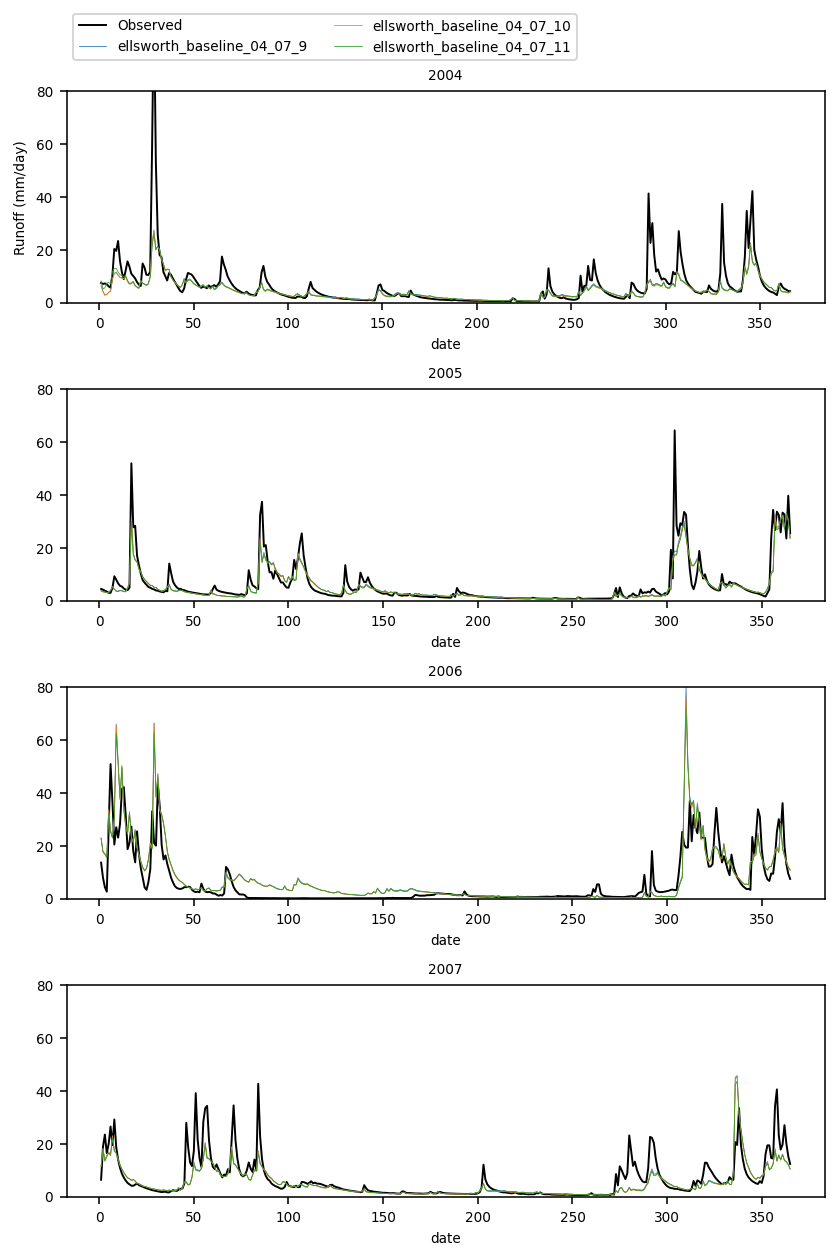

In [19]:
# Plotting a subset of simulations manually

sims_sub = ['ellsworth_baseline_04_07_9',
            'ellsworth_baseline_04_07_10',
            'ellsworth_baseline_04_07_11']

tuples = pd.MultiIndex.from_product([sims_sub, years])

runoff_sim_yearly_sub = runoff_sim_yearly[tuples]

years = runoff_obs_yearly.columns.get_level_values(0)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for i, year in enumerate(years):
    runoff_obs_yearly.iloc[:, i].plot(ax=axes[i], label='Observed', linewidth=1, color='black')
    axes[i].set_title(year)
    axes[i].set_ylim([0, 80])
    for j, sim in enumerate(sims_sub):
        col = (j * len(years)) + i
        runoff_sim_yearly_sub.iloc[:, col].plot(ax=axes[i], label=sim, linewidth=0.4)
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.4), fancybox=True, ncol=2)
axes[0].set_ylabel('Runoff (mm/day)')
plt.tight_layout()

#### Ensemble: averaging simulated runoff using PRISM and gauge precip data

In [16]:
selection = pd.MultiIndex.from_product([['ellsworth_baseline_04_07_10'], [2004, 2005, 2006, 2007]])
prism = runoff_sim_yearly[selection]

selection = pd.MultiIndex.from_product([['ellsworth_baseline_04_07_10_GHCND'], [2004, 2005, 2006, 2007]])
gauge = runoff_sim_yearly[selection]

avg_runoffs = []
for i, col in enumerate(gauge.columns):
    avg_runoff = np.mean([gauge.iloc[:, i], prism.iloc[:, i]], axis=0)
    avg_runoffs.append(avg_runoff)

avg_runoffs_df = pd.DataFrame(data=np.column_stack(avg_runoffs), columns=[2004, 2005, 2006, 2007])

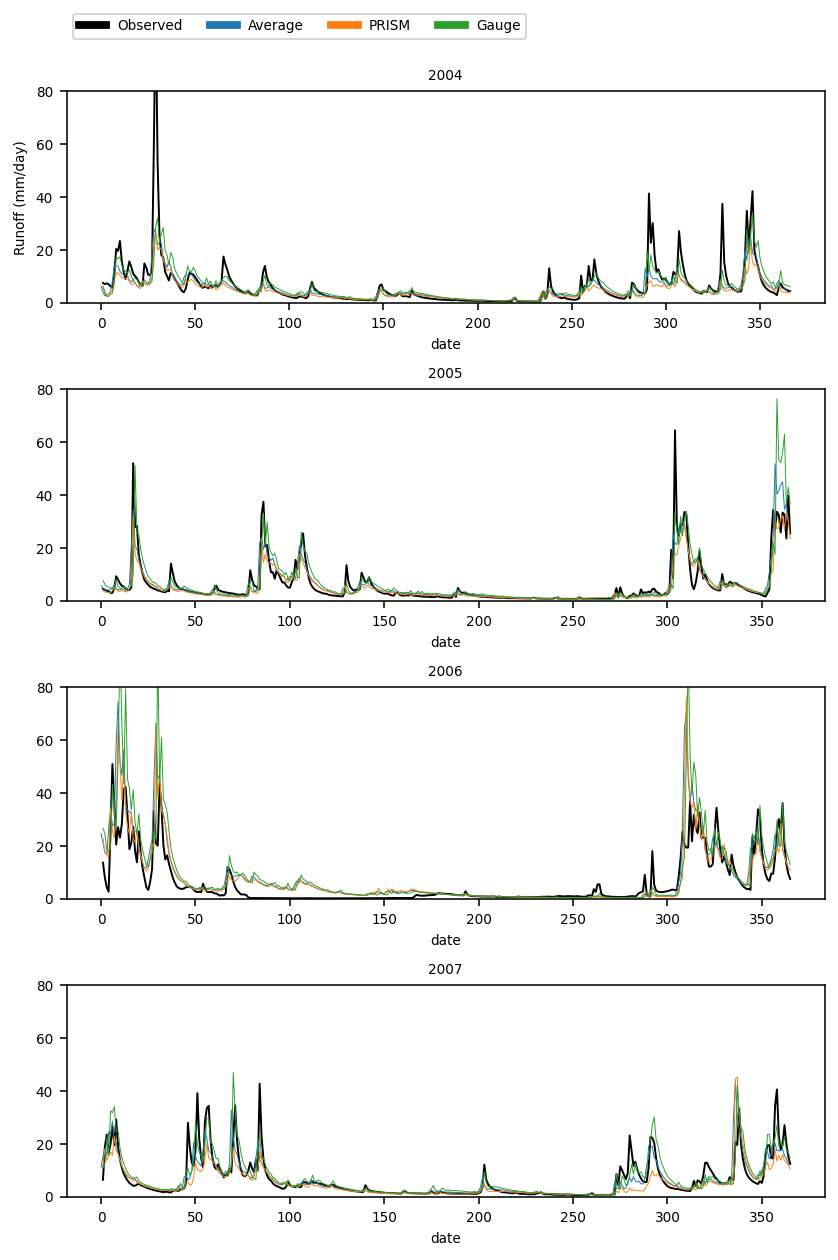

In [20]:
# Plotting PRISM, gauge, and average of PRISM and gauge runoffs

years = [2004, 2005, 2006, 2007]
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for i, year in enumerate(years):
    runoff_obs_yearly.iloc[:, i].plot(ax=axes[i], label='Observed', linewidth=1, color='black')
    axes[i].set_title(year)
    axes[i].set_ylim([0, 80])
    avg_runoffs_df.iloc[:, i].plot(ax=axes[i], label='Average', linewidth=0.5)
    prism.iloc[:, i].plot(ax=axes[i], label='PRISM', linewidth=0.5)
    gauge.iloc[:, i].plot(ax=axes[i], label='Gauge', linewidth=0.5)
    leg = axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.4), fancybox=True, ncol=4)
    for line in leg.get_lines():
        line.set_linewidth(4.0)
axes[0].set_ylabel('Runoff (mm/day)')
plt.tight_layout()

In [23]:
gauge

ellsworth_baseline_04_07_10_GHCND                                 
date                              2004       2005       2006       2007
date                                                                   
1                             5.951293   7.634514  26.618570  10.789105
2                             3.489241   6.177514  24.720856  12.281318
3                             2.288531   5.428402  18.353373  22.471651
4                             2.415826   5.089087  17.825466  15.545039
5                             3.038912   4.786254  18.942703  32.463173
...                                ...        ...        ...        ...
362                           7.584746  62.947025  21.590527  22.711872
363                           6.677496  36.036469  18.041492  17.805464
364                           6.584325  42.945370  15.543103  16.841047
365                           6.374254  36.599518  12.986013  14.633612
366                           5.937367        NaN        NaN        NaN

[366 rows x 4 columns]

In [35]:
# Computing Nash-Sutcliffe
def NS(s, o):
    """
        Nash Sutcliffe efficiency coefficient
        input:
        s: simulated
        o: observed
        output:
        ns: Nash Sutcliffe efficient coefficient
        """
    # s,o = filter_nan(s,o)
    return 1 - np.nansum((s-o)**2)/np.nansum((o-np.nanmean(o))**2)

display('NS (PRISM): ', NS(prism.to_numpy().flatten(), runoff_obs_yearly.to_numpy().flatten()))

display('NS (gauge): ', NS(gauge.to_numpy().flatten(), runoff_obs_yearly.to_numpy().flatten()))

display('NS (average): ', NS(avg_runoffs_df.to_numpy().flatten(), runoff_obs_yearly.to_numpy().flatten()))

'NS (PRISM): '

0.5439779433528131

'NS (gauge): '

0.4364795401906184

'NS (average): '

0.5846457059465486

The average of PRISM and gauge runoff has a higher NSE than their individual scores, so perhaps running VELMA with their averaged precipiation will lead to higher NSE as well.